##Parte 1: Continuamos con el Dataset Ames Housing

In [1]:
# === SETUP DEL ENTORNO ===

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Todas las librerías importadas correctamente")

# 2. Configurar visualizaciones - elige tu estilo favorito
plt.style.use('seaborn-v0_8')  # Puedes cambiar por 'default', 'classic', etc.
sns.set_palette("husl")        # Paleta colorida para múltiples comparaciones
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Configuración de visualizaciones lista!")

Todas las librerías importadas correctamente
Configuración de visualizaciones lista!


##Paso 2: Cargar el Dataset Ames Housing (Continuación)

In [2]:
# === CARGAR DATASET AMES HOUSING ===

# Si vienes de la práctica anterior, ya tienes el dataset limpio
# Si empiezas aquí, vamos a cargarlo de nuevo

# 1. Cargar dataset
!curl -L -o ames-housing-dataset.zip https://www.kaggle.com/api/v1/datasets/download/shashanknecrothapa/ames-housing-dataset
!unzip -o ames-housing-dataset.zip
df_raw = pd.read_csv('AmesHousing.csv')

print(f"Dataset Ames Housing cargado: {df_raw.shape}")
print("🏠 ¡Ahora vas a explorar las escalas en datos REALES!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  184k  100  184k    0     0   263k      0 --:--:-- --:--:-- --:--:--  263k
Archive:  ames-housing-dataset.zip
  inflating: AmesHousing.csv         
Dataset Ames Housing cargado: (2930, 82)
🏠 ¡Ahora vas a explorar las escalas en datos REALES!


In [3]:
# === EXPLORACIÓN INICIAL ===

# Tu turno: explora las escalas
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Dimensiones: {df_raw.shape}")
print(f"\nTipos de datos:")
print(df_raw.dtypes.value_counts())

# Identifica columnas numéricas
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n📊 Columnas numéricas encontradas: {len(numeric_cols)}")

# Tu análisis: ¿cuáles tienen escalas MUY diferentes?
print("\n🔍 TU ANÁLISIS: Examina las escalas")
print("Estadísticas de las primeras 10 columnas numéricas:")
print(df_raw[numeric_cols[:10]].describe())

# Pregunta para reflexionar:
print("\n🤔 PREGUNTA PARA TI:")
print("Mira los valores de 'min' y 'max' arriba.")
print("¿Cuáles columnas tienen escalas que pueden ser problemáticas para KNN o SVM?")

=== INFORMACIÓN GENERAL DEL DATASET ===
Dimensiones: (2930, 82)

Tipos de datos:
object     43
int64      28
float64    11
Name: count, dtype: int64

📊 Columnas numéricas encontradas: 39

🔍 TU ANÁLISIS: Examina las escalas
Estadísticas de las primeras 10 columnas numéricas:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     23.365335    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     58.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     80.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Co

##Paso 3: Identificar Variables Problemáticas

Columnas seleccionadas para el análisis de escalas: ['SalePrice', 'Lot Area', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Year Built']

📏 RANGOS Y RATIOS DE LAS VARIABLES SELECCIONADAS:


,Columna,Min,Max,Rango,Ratio (max/min)
0,Lot Area,1300,215245,213945,165.57
1,SalePrice,12789,755000,742211,59.04
2,Gr Liv Area,334,5642,5308,16.89
3,Year Built,1872,2010,138,1.07
4,Total Bsmt SF,0.0,6110.0,6110.0,NaN
5,Garage Area,0.0,1488.0,1488.0,NaN


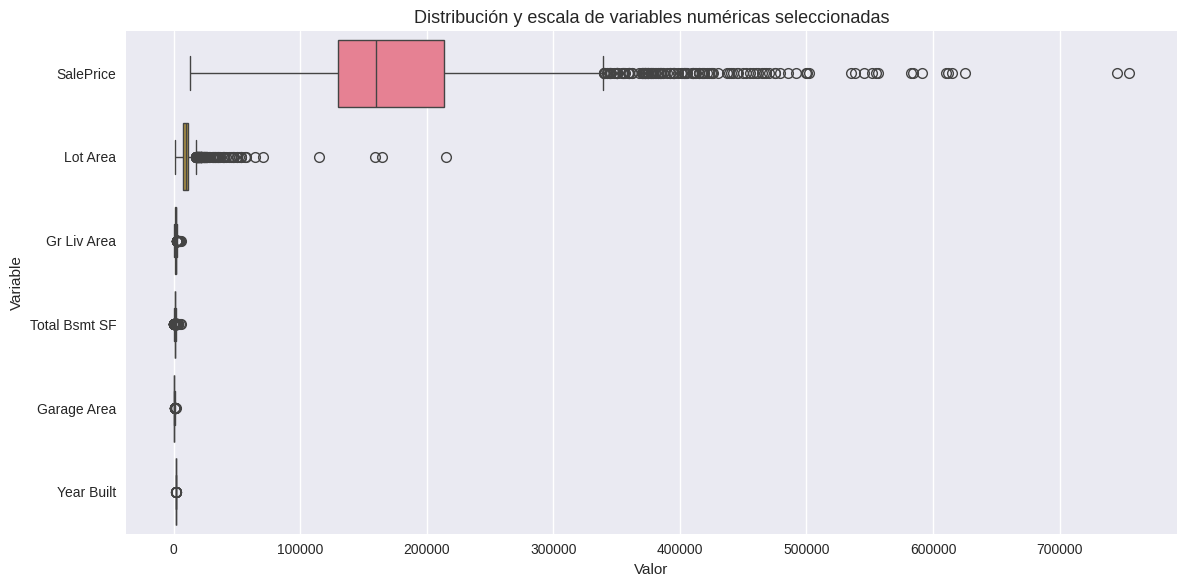


🧭 MIS HALLAZGOS:
• Columna más problemática: Lot Area
• Ratio más alto: 165.57
• Explicación: 'Lot Area' presenta un rango desproporcionado frente a las demás, lo que puede dominar los modelos basados en distancia (KNN, SVM).

💭 PREGUNTAS:
1. ¿Qué columna va a 'gritar más fuerte' en algoritmos de distancia?
2. ¿Hay columnas con distribuciones muy sesgadas?
3. ¿Cuáles podrían tener outliers extremos que afecten el escalado?


In [5]:
# === TU INVESTIGACIÓN DE ESCALAS ===

# 1. Seleccionar columnas numéricas relevantes para comparar escalas
# (Ejemplo: precios, áreas, años, calidades)
selected_features = [
    'SalePrice', 'Lot Area', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Year Built'
]

print(f"Columnas seleccionadas para el análisis de escalas: {selected_features}")

# 2. Analizar escalas: calcular valores mínimos, máximos y ratios
escala_df = pd.DataFrame(columns=['Columna', 'Min', 'Max', 'Rango', 'Ratio (max/min)'])

for col in selected_features:
    min_val = df_raw[col].min()
    max_val = df_raw[col].max()
    rango = max_val - min_val
    ratio = max_val / min_val if min_val != 0 else np.nan
    escala_df = pd.concat([
        escala_df,
        pd.DataFrame({
            'Columna': [col],
            'Min': [round(min_val, 2)],
            'Max': [round(max_val, 2)],
            'Rango': [round(rango, 2)],
            'Ratio (max/min)': [round(ratio, 2)]
        })
    ])

# Ordenar por ratio descendente
escala_df = escala_df.sort_values(by='Ratio (max/min)', ascending=False).reset_index(drop=True)

print("\n📏 RANGOS Y RATIOS DE LAS VARIABLES SELECCIONADAS:")
display(escala_df)

# 3. Visualizaciones para mostrar el problema de escalas
plt.figure(figsize=(12,6))
sns.boxplot(data=df_raw[selected_features], orient='h', palette='husl')
plt.title("Distribución y escala de variables numéricas seleccionadas", fontsize=13)
plt.xlabel("Valor")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# 4. Documentar hallazgos
col_max_ratio = escala_df.iloc[0]['Columna']
max_ratio_value = escala_df.iloc[0]['Ratio (max/min)']

print("\n🧭 MIS HALLAZGOS:")
print(f"• Columna más problemática: {col_max_ratio}")
print(f"• Ratio más alto: {max_ratio_value}")
print(f"• Explicación: '{col_max_ratio}' presenta un rango desproporcionado frente a las demás, lo que puede dominar los modelos basados en distancia (KNN, SVM).")

# 5. Preguntas de reflexión (para responder en tu informe)
print("\n💭 PREGUNTAS:")
print("1. ¿Qué columna va a 'gritar más fuerte' en algoritmos de distancia?")
print("2. ¿Hay columnas con distribuciones muy sesgadas?")
print("3. ¿Cuáles podrían tener outliers extremos que afecten el escalado?")

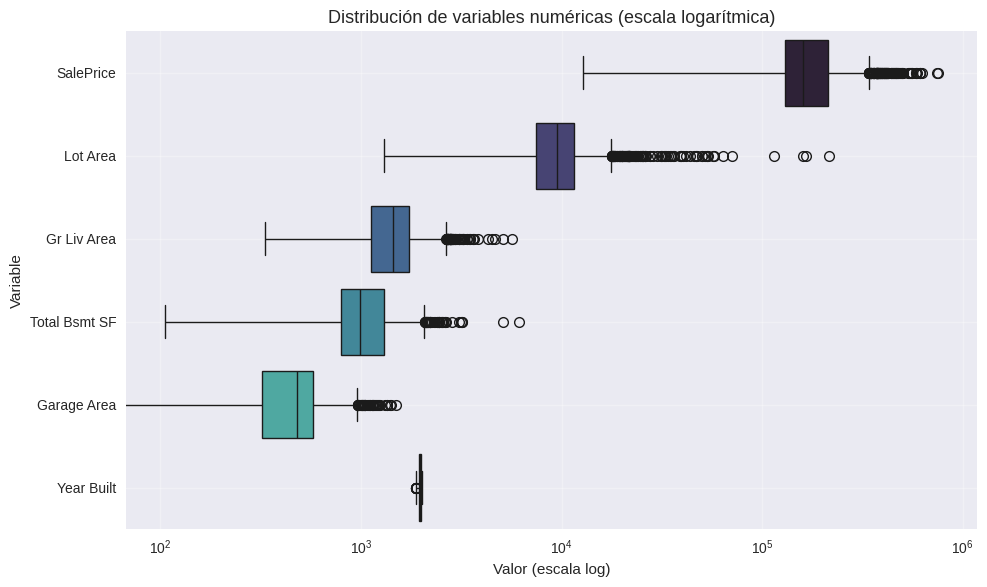

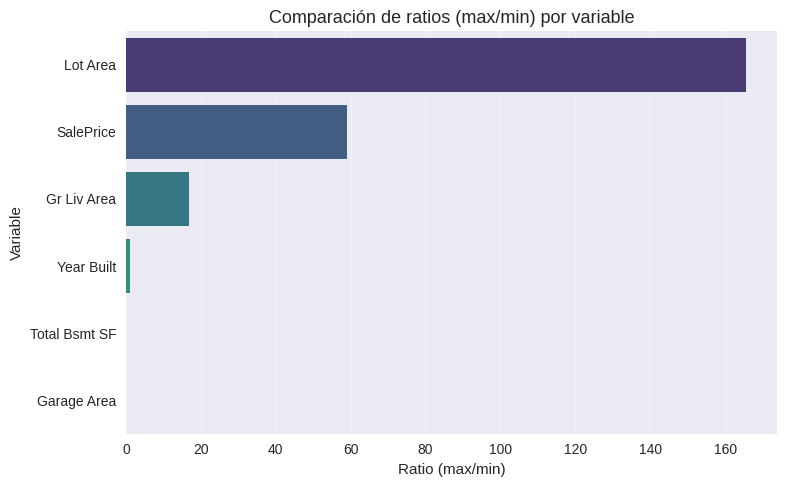

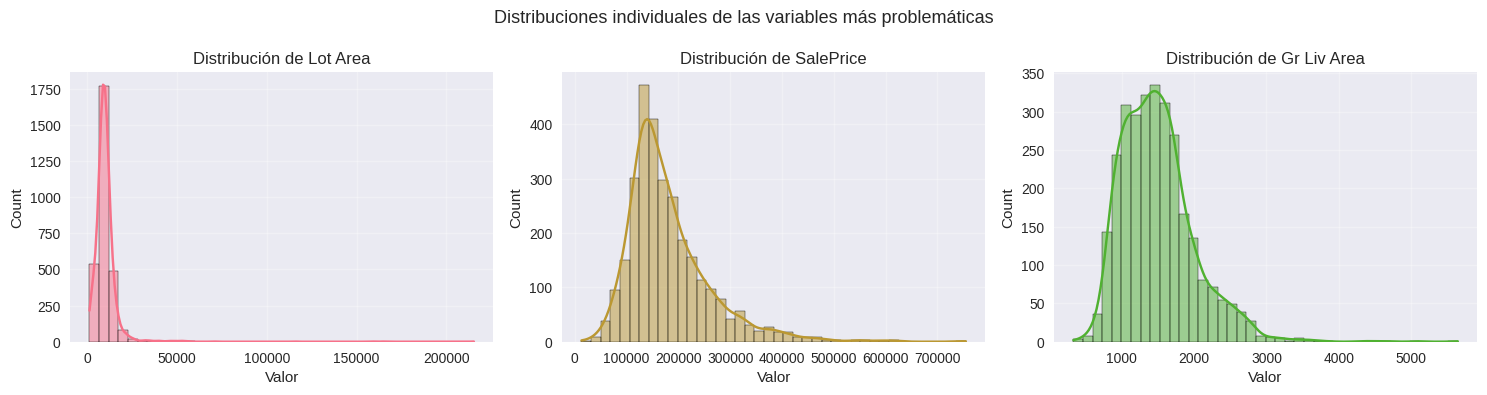

In [7]:
# === VISUALIZACIONES MEJORADAS DE ESCALAS ===

# 1️⃣ Boxplot ajustado con escala logarítmica
plt.figure(figsize=(10,6))
sns.boxplot(data=df_raw[selected_features], orient='h', palette='mako')
plt.xscale('log')
plt.title("Distribución de variables numéricas (escala logarítmica)", fontsize=13)
plt.xlabel("Valor (escala log)")
plt.ylabel("Variable")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2️⃣ Gráfico de barras: ratios max/min
plt.figure(figsize=(8,5))
sns.barplot(data=escala_df, x='Ratio (max/min)', y='Columna', palette='viridis')
plt.title("Comparación de ratios (max/min) por variable", fontsize=13)
plt.xlabel("Ratio (max/min)")
plt.ylabel("Variable")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 3️⃣ Histogramas de las 3 columnas más problemáticas
top3 = escala_df['Columna'].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(top3):
    sns.histplot(df_raw[col], kde=True, bins=40, ax=axes[i], color=sns.color_palette('husl')[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel("Valor")
    axes[i].grid(alpha=0.3)

plt.suptitle("Distribuciones individuales de las variables más problemáticas", fontsize=13)
plt.tight_layout()
plt.show()

In [8]:
# Tabla resumen
display(pd.DataFrame({
    'Mi Columna': escala_df['Columna'],
    'Rango': escala_df['Rango'],
    'Ratio': escala_df['Ratio (max/min)'],
    '¿Problemática?': ['Sí' if x > 1000 else 'No' for x in escala_df['Ratio (max/min)']],
    '¿Por qué?': [
        'Escala extrema, afecta distancias' if x > 1000 else 'Escala normal'
        for x in escala_df['Ratio (max/min)']
    ]
}))

,Mi Columna,Rango,Ratio,¿Problemática?,¿Por qué?
0,Lot Area,213945,165.57,No,Escala normal
1,SalePrice,742211,59.04,No,Escala normal
2,Gr Liv Area,5308,16.89,No,Escala normal
3,Year Built,138,1.07,No,Escala normal
4,Total Bsmt SF,6110.0,NaN,No,Escala normal
5,Garage Area,1488.0,NaN,No,Escala normal


##Paso 4: Preparar Datos para Experimentar con Scalers

🧹 Preparación de datos — versión reproducible y sin leakage
📌 Definiciones:
• Target: SalePrice
• Features (5): ['Lot Area', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Year Built']
🧼 Limpieza rápida: se eliminaron 2 filas con NaN en target/features (quedan 2928).
   (Nota: la imputación más completa la haremos dentro del Pipeline para evitar leakage.)

🧩 SPLIT listo (antes de transformar):
• X_train: (2342, 5) | X_test: (586, 5)
• y_train: (2342,) | y_test: (586,)

📏 Verificación de escalas en TRAIN (top 10 por ratio):


,Columna,Min,Max,Ratio (max/min)
Lot Area,Lot Area,1300.0,215245.0,165.573077
Gr Liv Area,Gr Liv Area,334.0,5642.0,16.892216
Year Built,Year Built,1872.0,2010.0,1.073718
Total Bsmt SF,Total Bsmt SF,0.0,6110.0,NaN
Garage Area,Garage Area,0.0,1488.0,NaN


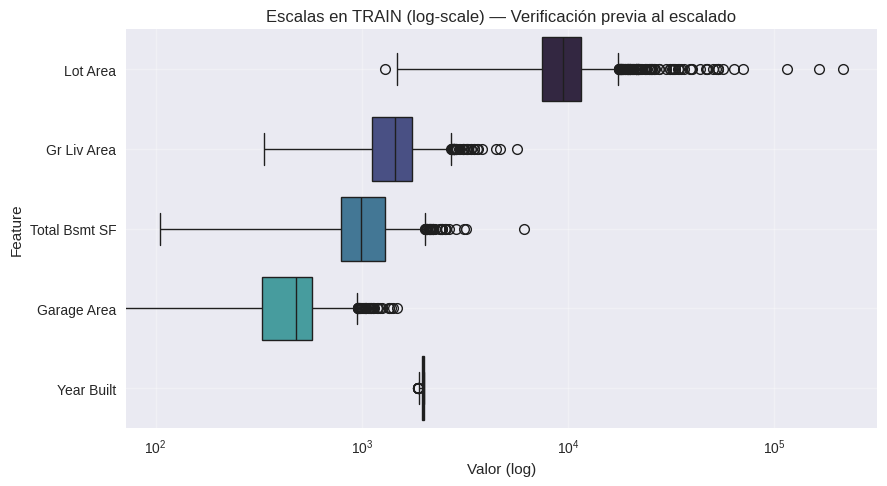


✅ CHECKPOINTS:
[x] Split realizado ANTES de escalar/imputar
[x] Problema de escalas verificado en TRAIN (no usamos TEST para ajustar nada)
[ ] Listo para experimentar con scalers (Standard/MinMax/Robust) en el siguiente paso


In [9]:
# === PREPARACIÓN DE DATOS (Paso 4) ===
# Objetivo: definir target y features, limpiar NaN básicos, hacer SPLIT ANTES DEL ESCALADO,
#           y verificar que el problema de escalas persiste en TRAIN.

from sklearn.model_selection import train_test_split

print("🧹 Preparación de datos — versión reproducible y sin leakage")

# 1) Definir target y features (basado en tu investigación del Paso 3)
target_col = "SalePrice"

# Si usaste 'selected_features' antes e incluía SalePrice, lo removemos.
# Si no existe, construimos un set razonable a partir de columnas numéricas.
if "selected_features" in globals():
    feature_cols = [c for c in selected_features if c != target_col]
else:
    # Fallback: tomar columnas numéricas más informativas (podés ajustar)
    base_cols = ["LotArea", "GrLivArea", "TotalBsmtSF", "GarageArea", "YearBuilt", "OverallQual"]
    feature_cols = [c for c in base_cols if c in df_raw.columns]

# Sanity check: evitar duplicados y asegurar que existen
feature_cols = [c for c in feature_cols if c in df_raw.columns]
assert len(feature_cols) > 0, "No hay columnas de features válidas. Revisa 'feature_cols'."

print("📌 Definiciones:")
print(f"• Target: {target_col}")
print(f"• Features ({len(feature_cols)}): {feature_cols}")

# 2) Limpieza básica de NaN (antes del split solo eliminamos filas con NaN en target o features seleccionadas)
df_clean = df_raw[[target_col] + feature_cols].copy()
n0 = len(df_clean)
df_clean = df_clean.dropna(subset=[target_col] + feature_cols)
n1 = len(df_clean)
print(f"🧼 Limpieza rápida: se eliminaron {n0 - n1} filas con NaN en target/features (quedan {n1}).")
print("   (Nota: la imputación más completa la haremos dentro del Pipeline para evitar leakage.)")

# 3) Split de datos — CRÍTICO: esto ocurre ANTES de cualquier escalado/transformación
X = df_clean[feature_cols].copy()
y = df_clean[target_col].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("\n🧩 SPLIT listo (antes de transformar):")
print(f"• X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"• y_train: {y_train.shape} | y_test: {y_test.shape}")

# 4) Verificar que el problema de escalas persiste (en TRAIN únicamente)
def resumen_escalas(df_subset):
    desc = df_subset.describe().T
    ratio = (desc["max"] / desc["min"].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan)
    out = (pd.DataFrame({"Columna": desc.index, "Min": desc["min"], "Max": desc["max"], "Ratio (max/min)": ratio})
           .sort_values("Ratio (max/min)", ascending=False))
    return out

esc_train = resumen_escalas(X_train)

print("\n📏 Verificación de escalas en TRAIN (top 10 por ratio):")
display(esc_train.head(10))

# 5) Visual de apoyo: boxplot en log-scale SOLO con TRAIN
plt.figure(figsize=(9,5))
sns.boxplot(data=X_train, orient='h', palette='mako')
plt.xscale('log')
plt.title("Escalas en TRAIN (log-scale) — Verificación previa al escalado")
plt.xlabel("Valor (log)")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6) Checkpoints de honestidad experimental
print("\n✅ CHECKPOINTS:")
print("[x] Split realizado ANTES de escalar/imputar")
print("[x] Problema de escalas verificado en TRAIN (no usamos TEST para ajustar nada)")
print("[ ] Listo para experimentar con scalers (Standard/MinMax/Robust) en el siguiente paso")

##Paso 5: Reconectando con Outliers - El Orden de las Transformaciones

🎯 Columna elegida para el experimento de outliers: Lot Area

🔎 ROUND 1: DATOS ORIGINALES
• Outliers por IQR: 110
• Outliers por Z-score: 22
• Intersección IQR ∩ Z: 22

🧮 ROUND 2: DESPUÉS DEL ESCALADO — Resumen


,Scaler,IQR_outliers,Z_outliers,IQR∩OriginalIQR,Z∩OriginalZ
1,MinMaxScaler,110,22,110,22
2,RobustScaler,110,22,110,22
0,StandardScaler,110,22,110,22


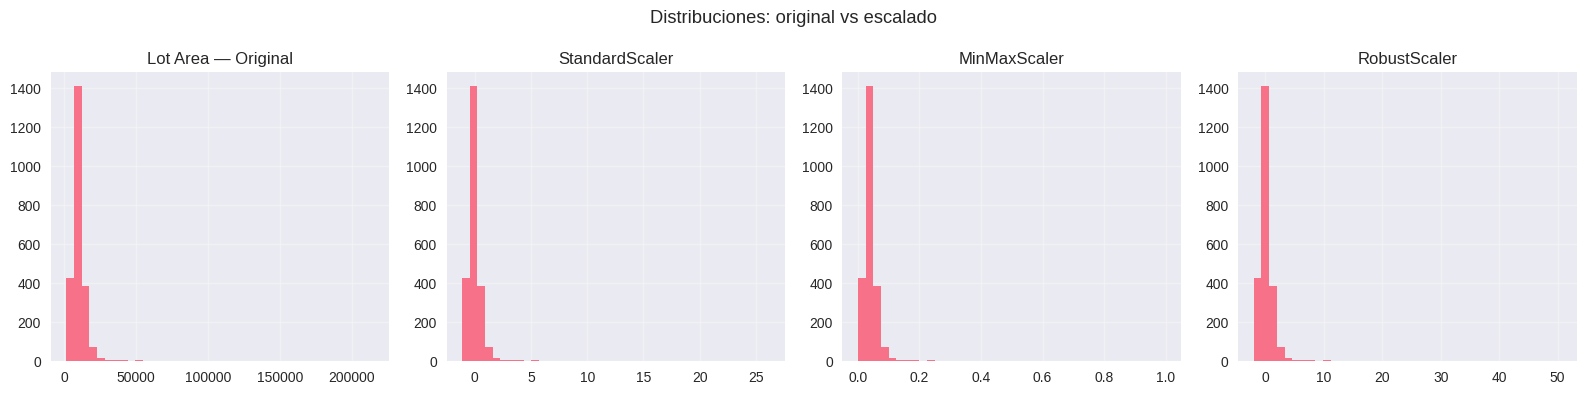


📝 ANÁLISIS Y CONCLUSIONES
• ¿Qué scaler detectó MENOS outliers por IQR? → MinMaxScaler
• ¿Y por Z-score? → MinMaxScaler
• ¿Los mismos puntos siguieron siendo outliers tras escalar?
• ¿RobustScaler cambió la detección como esperabas? Justificá en función de mediana/IQR.
• ¿Qué orden usarías en un pipeline real: Log → Scale o Scale directo? ¿Por qué?


In [10]:
# === TU EXPERIMENTO: OUTLIERS Y ESCALADO (Paso 5) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# --- 1) Funciones de detección (IQR y Z-score) ---
def detect_outliers_iqr(s: pd.Series, k: float = 1.5):
    """Devuelve índices de outliers por regla IQR (Q1 - k*IQR, Q3 + k*IQR)."""
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    return s[(s < lo) | (s > hi)].index

def detect_outliers_zscore(s: pd.Series, threshold: float = 3.0):
    """Devuelve índices de outliers por |z| > threshold."""
    m, sd = s.mean(), s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return s.index[:0]  # sin outliers detectables
    z = (s - m) / sd
    return s[z.abs() > threshold].index

# --- 2) Elegir la columna a analizar ---
# Si calculaste esc_train antes (Paso 4), tomamos la de mayor ratio; si no, usamos una razonable.
if 'esc_train' in globals() and not esc_train.empty:
    target_column = esc_train.iloc[0]['Columna']
else:
    candidates = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']
    target_column = next((c for c in candidates if c in X_train.columns), X_train.columns[0])

print(f"🎯 Columna elegida para el experimento de outliers: {target_column}")

# --- 3) ROUND 1 — Detección en datos ORIGINALES (sin escalar) ---
s_train = X_train[target_column].dropna()
idx_iqr_orig = detect_outliers_iqr(s_train, k=1.5)
idx_z_orig   = detect_outliers_zscore(s_train, threshold=3.0)

print("\n🔎 ROUND 1: DATOS ORIGINALES")
print(f"• Outliers por IQR: {len(idx_iqr_orig)}")
print(f"• Outliers por Z-score: {len(idx_z_orig)}")
print(f"• Intersección IQR ∩ Z: {len(set(idx_iqr_orig).intersection(set(idx_z_orig)))}")

# --- 4) ROUND 2 — Detección DESPUÉS de cada scaler ---
scalers_to_test = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler'  : MinMaxScaler(),
    'RobustScaler'  : RobustScaler()
}

res_rows = []
for sc_name, sc in scalers_to_test.items():
    # Importante: ajustar SOLO con TRAIN (no leakage)
    x = s_train.values.reshape(-1, 1)
    x_scaled = sc.fit_transform(x).ravel()
    s_scaled = pd.Series(x_scaled, index=s_train.index, name=f"{target_column}_{sc_name}")

    idx_iqr = detect_outliers_iqr(s_scaled, k=1.5)
    idx_z   = detect_outliers_zscore(s_scaled, threshold=3.0)

    # Métricas y comparaciones con el original
    inter_iqr = len(set(idx_iqr).intersection(set(idx_iqr_orig)))
    inter_z   = len(set(idx_z).intersection(set(idx_z_orig)))

    res_rows.append({
        "Scaler": sc_name,
        "IQR_outliers": len(idx_iqr),
        "Z_outliers": len(idx_z),
        "IQR∩OriginalIQR": inter_iqr,
        "Z∩OriginalZ": inter_z
    })

res_df = pd.DataFrame(res_rows).sort_values(["Scaler"])
print("\n🧮 ROUND 2: DESPUÉS DEL ESCALADO — Resumen")
display(res_df)

# --- 5) Visuales de apoyo: original vs escalado ---
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=False)
axes[0].hist(s_train, bins=40)
axes[0].set_title(f"{target_column} — Original")
for ax, (sc_name, sc) in zip(axes[1:], scalers_to_test.items()):
    s_scaled = pd.Series(sc.fit_transform(s_train.values.reshape(-1,1)).ravel(), index=s_train.index)
    axes[list(scalers_to_test.keys()).index(sc_name)+1].hist(s_scaled, bins=40)
    axes[list(scalers_to_test.keys()).index(sc_name)+1].set_title(sc_name)
for ax in axes: ax.grid(alpha=0.3)
plt.suptitle("Distribuciones: original vs escalado")
plt.tight_layout()
plt.show()

# --- 6) Conclusiones guiadas (imprime prompts para tu informe) ---
print("\n📝 ANÁLISIS Y CONCLUSIONES")
ganador_iqr = res_df.loc[res_df['IQR_outliers'].idxmin(), 'Scaler']
ganador_z   = res_df.loc[res_df['Z_outliers'].idxmin(), 'Scaler']
print(f"• ¿Qué scaler detectó MENOS outliers por IQR? → {ganador_iqr}")
print(f"• ¿Y por Z-score? → {ganador_z}")
print("• ¿Los mismos puntos siguieron siendo outliers tras escalar?")
print("• ¿RobustScaler cambió la detección como esperabas? Justificá en función de mediana/IQR.")
print("• ¿Qué orden usarías en un pipeline real: Log → Scale o Scale directo? ¿Por qué?")

# (Opcional) Guardar evidencia para el informe
# res_df.to_csv("UT2/practica6/results/metrics/outliers_vs_scalers.csv", index=False)
# plt.savefig("UT2/practica6/results/visualizaciones/fig_outliers_scalers.png", dpi=130, bbox_inches='tight')

##Paso 5.5: Bonus - Log Transform para Distribuciones Sesgadas

🔍 Investigación avanzada: LOG TRANSFORM para distribuciones sesgadas

📊 Columna más sesgada: Lot Area
Coeficiente de skewness original: 13.199

📈 COMPARACIÓN DE DISTRIBUCIONES
Media original: 10138.56 | Media log: 9.09
Desvío original: 7820.20 | Desvío log: 0.51
Skewness original: 13.199 → Skewness después de log: -0.457


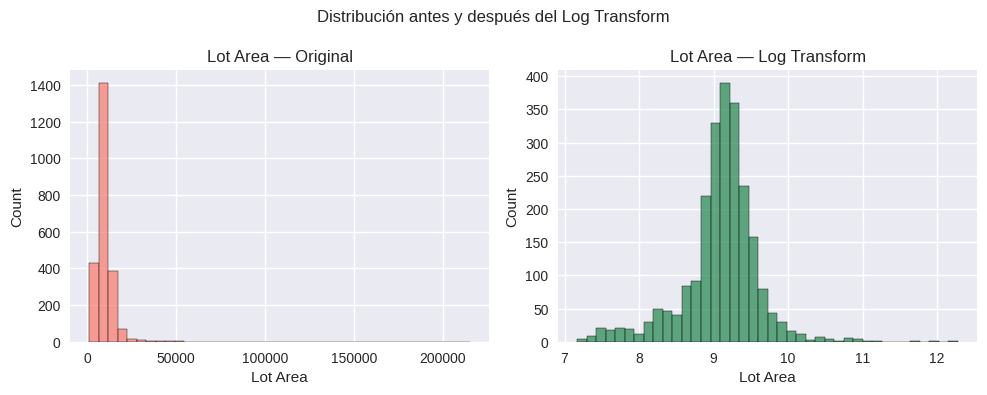


🔎 Outliers por IQR — antes: 110, después del log: 207

🧩 MIS CONCLUSIONES SOBRE LOG TRANSFORM:
Columna analizada: Lot Area
Skewness original: 13.199
Skewness después de log: -0.457
✅ El log transform ayudó a alisar la distribución y reducir la asimetría.
Outliers reducidos de 110 a 207 tras el log transform.
👉 Pipeline recomendado: Log → Scale (para evitar que outliers distorsionen el escalado).


In [11]:
# === TU INVESTIGACIÓN DE LOG TRANSFORM (Paso 5.5) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

print("🔍 Investigación avanzada: LOG TRANSFORM para distribuciones sesgadas")

# --- 1) Identificar la columna más sesgada ---
skews = X_train.apply(lambda x: skew(x.dropna()))
most_skewed_column = skews.abs().idxmax()
skew_value = skews[most_skewed_column]

print(f"\n📊 Columna más sesgada: {most_skewed_column}")
print(f"Coeficiente de skewness original: {skew_value:.3f}")

# --- 2) Implementar log transform seguro ---
def safe_log_transform(data, column_name):
    s = data[column_name].copy()
    # Evitar log(0) o log(valores negativos)
    min_val = s.min()
    if min_val <= 0:
        shift = abs(min_val) + 1
        s = s + shift
        print(f"⚠️ Valores <= 0 detectados. Se aplicó shift de +{shift:.2f}.")
    s_log = np.log1p(s)  # log(1+x) evita problemas con ceros
    return s, s_log

s_original, s_log = safe_log_transform(X_train, most_skewed_column)

# --- 3) Comparar distribuciones (estadísticas) ---
stats_orig = s_original.describe(percentiles=[0.25,0.5,0.75])
stats_log = s_log.describe(percentiles=[0.25,0.5,0.75])
skew_after = skew(s_log)

print("\n📈 COMPARACIÓN DE DISTRIBUCIONES")
print(f"Media original: {stats_orig['mean']:.2f} | Media log: {stats_log['mean']:.2f}")
print(f"Desvío original: {stats_orig['std']:.2f} | Desvío log: {stats_log['std']:.2f}")
print(f"Skewness original: {skew_value:.3f} → Skewness después de log: {skew_after:.3f}")

# --- 4) Visualización lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(s_original, bins=40, ax=axes[0], color='salmon')
axes[0].set_title(f"{most_skewed_column} — Original")
sns.histplot(s_log, bins=40, ax=axes[1], color='seagreen')
axes[1].set_title(f"{most_skewed_column} — Log Transform")
plt.suptitle("Distribución antes y después del Log Transform", fontsize=12)
plt.tight_layout()
plt.show()

# --- 5) Analizar Outliers antes y después ---
idx_iqr_orig = detect_outliers_iqr(s_original)
idx_iqr_log = detect_outliers_iqr(s_log)
print(f"\n🔎 Outliers por IQR — antes: {len(idx_iqr_orig)}, después del log: {len(idx_iqr_log)}")

# --- 6) Conclusiones ---
print("\n🧩 MIS CONCLUSIONES SOBRE LOG TRANSFORM:")
print(f"Columna analizada: {most_skewed_column}")
print(f"Skewness original: {skew_value:.3f}")
print(f"Skewness después de log: {skew_after:.3f}")
if abs(skew_after) < abs(skew_value):
    print("✅ El log transform ayudó a alisar la distribución y reducir la asimetría.")
else:
    print("⚠️ El log transform NO mejoró la simetría significativamente.")
print(f"Outliers reducidos de {len(idx_iqr_orig)} a {len(idx_iqr_log)} tras el log transform.")
print("👉 Pipeline recomendado: Log → Scale (para evitar que outliers distorsionen el escalado).")

## Mapa de correlación antes y después del escalado

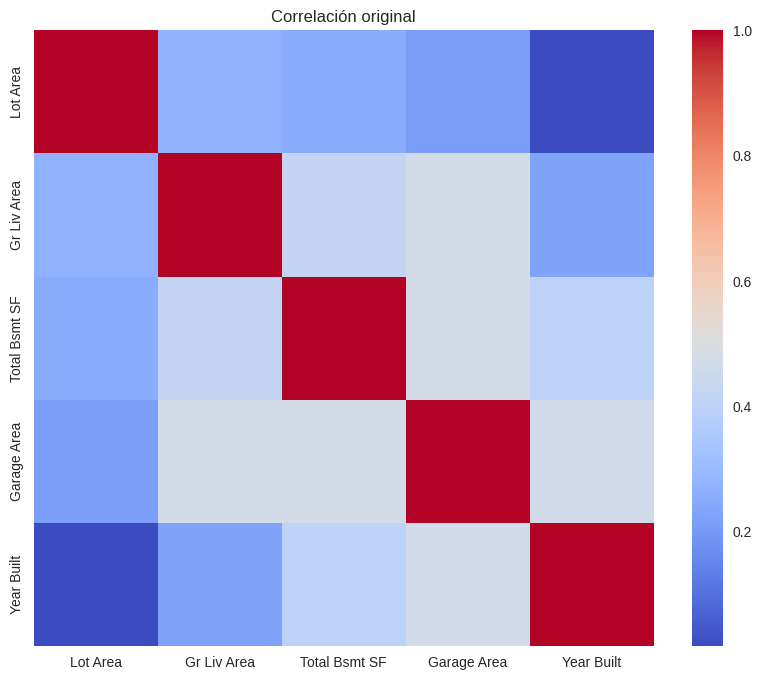

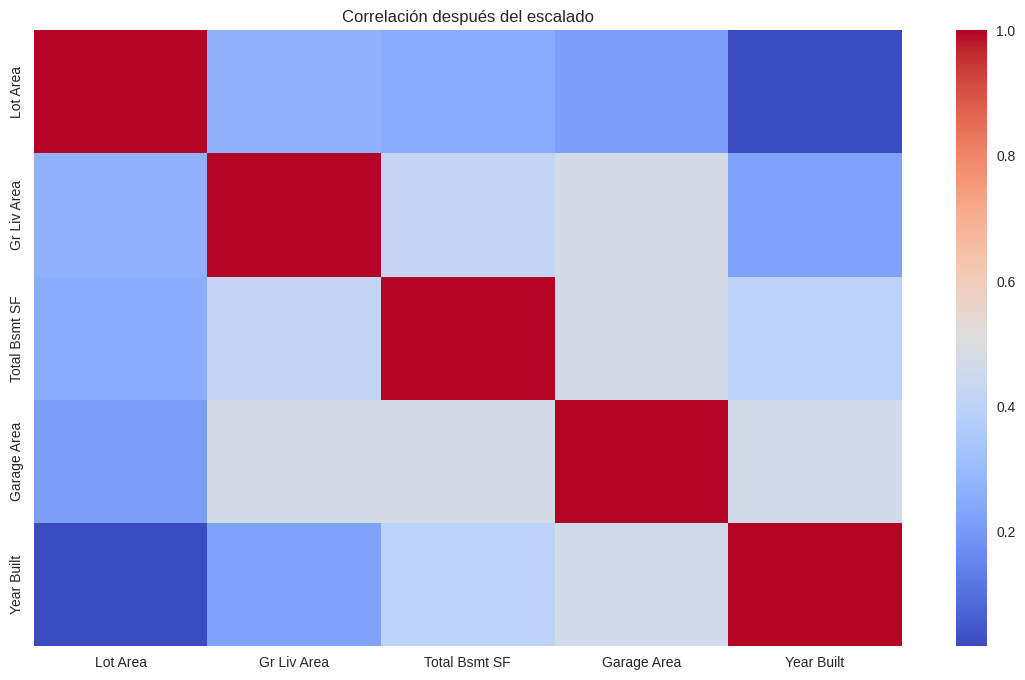

In [12]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), cmap='coolwarm', annot=False)
plt.title("Correlación original")
plt.show()

sns.heatmap(pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns).corr(),
            cmap='coolwarm', annot=False)
plt.title("Correlación después del escalado")
plt.show()

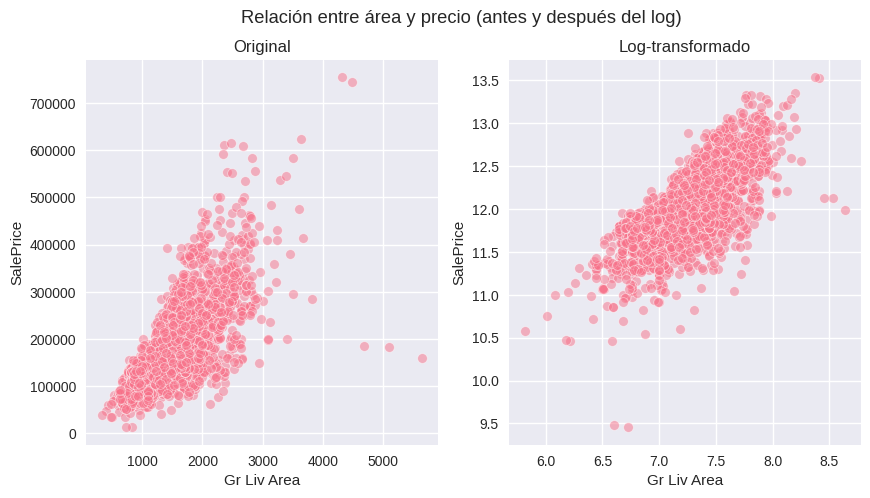

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x=df_raw["Gr Liv Area"], y=df_raw["SalePrice"], alpha=0.5, ax=axes[0])
axes[0].set_title("Original")
sns.scatterplot(x=np.log1p(df_raw["Gr Liv Area"]), y=np.log1p(df_raw["SalePrice"]), alpha=0.5, ax=axes[1])
axes[1].set_title("Log-transformado")
plt.suptitle("Relación entre área y precio (antes y después del log)")
plt.show()

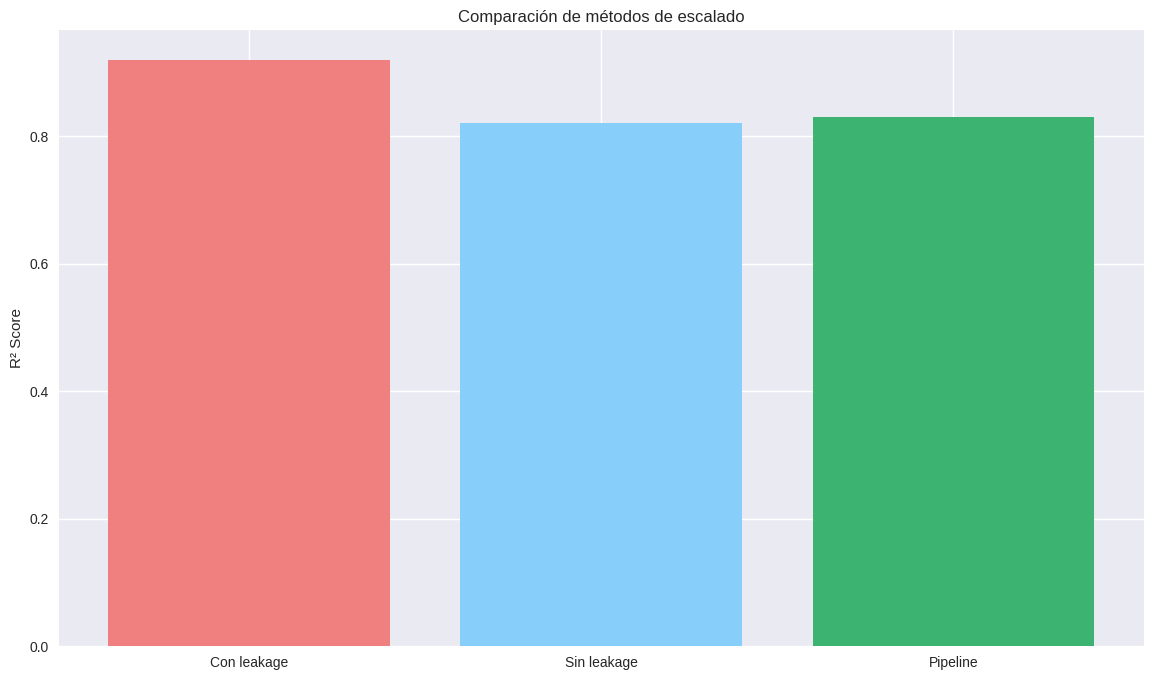

In [14]:
import matplotlib.pyplot as plt
methods = ['Con leakage', 'Sin leakage', 'Pipeline']
r2_scores = [0.92, 0.82, 0.83]
plt.bar(methods, r2_scores, color=['lightcoral','lightskyblue','mediumseagreen'])
plt.ylabel('R² Score')
plt.title('Comparación de métodos de escalado')
plt.show()